In [193]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)
import ROOT
from ROOT import TChain, TTree,TCanvas,TH1F,TList,TFile,TH2F,TPaveLabel,TPaveText,TLorentzVector,TLegend
import json

## Create root file for creating a histogram needed for nodes reweighting

In [2]:
#file_dir = '/shome/nchernya/CMSSW_9_4_9/src/flashgg/output_oldnodes2016_30_01_2018/'   #2016 old nodes
file_dir = '/shome/nchernya/HHbbgg_ETH_devel/root_files/HHreweighting_01_02_2018/'   #2017 nodes 
out_dir = '/shome/nchernya/HHbbgg_ETH_devel/root_files/HHreweighting_14_02_2018/'
year = '2017'
#outname = 'output_GluGluToHHTo2B2G_mix12nodes_13TeV-madgraph_%s.root'%year
outname = 'output_GluGluToHHTo2B2G_mix6nodes_13TeV-madgraph_%s.root'%year
#inname = 'output_GluGluToHHTo2B2G_12nodes_13TeV-madgraph.root'
inname = 'output_GluGluToHHTo2B2G_6nodes_13TeV-madgraph_correctedcfg.root'

In [ ]:
out = TFile(out_dir+outname,'recreate')
gen_events_per_node = []
filename = file_dir+inname    
file = TFile(filename)
dirGen = file.GetDirectory('genDiphotonDumper')
dirGen = dirGen.GetDirectory('trees')
tlistGen = TList()
#for i in range(2,14): #for 2016
for i in [2,3,4,7,9,12]: #for 2017
    name = 'GluGluToHHTo2B2G_node_%d_13TeV_madgraph_correctedcfg_13TeV_DoubleHTag_0'%(i)
    name_all = 'GluGluToHHTo2B2G_node_%d_13TeV_madgraph_correctedcfg_13TeV_NoTag_0'%(i)
    treeGen = dirGen.Get(name)
    treeGen_all = dirGen.Get(name_all)
    tlistGen.Add(treeGen)
    tlistGen.Add(treeGen_all)
out.cd()
newtreeGen = (TTree.MergeTrees(tlistGen)).Clone('GluGluToHHTo2B2G_mixnodes_GenAll')
newtreeGen.SetName('GluGluToHHTo2B2G_mixnodes_GenAll')
newtreeGen.Write()
out.Close()

## Check reweighted nodes

In [106]:
#year = '2016'
year = '2017'
if year=='2017':
    file_dir = '/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017_20191303/'
    name='GluGluToHHTo2B2G_12nodes_13TeV_madgraph_correctedcfg_13TeV'
    inname = 'output_GluGluToHHTo2B2G_12nodes_13TeV-madgraph_2017'
if year=='2016':
    file_dir = '/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2016_20191303/'
    name='GluGluToHHTo2B2G_12nodes_13TeV_madgraph_13TeV'
    inname = 'output_GluGluToHHTo2B2G_12nodes_13TeV-madgraph_2016'
out_dir = file_dir

    
outname = inname+'_%s'%('merged')
inname +='.root'
outname+='.root'

In [107]:
out = TFile(out_dir+outname,'recreate')
gen_events_per_node = []
filename = file_dir+inname    
file = TFile(filename)

dir = file.GetDirectory('tagsDumper')
dir = dir.GetDirectory('trees')
tlist = TList()
tree = dir.Get(name+'_DoubleHTag_0')
tlist.Add(tree.Clone(name))

dirGen = file.GetDirectory('genDiphotonDumper')
dirGen = dirGen.GetDirectory('trees')
tlistGen = TList()
treeGen = dirGen.Get(name+'_DoubleHTag_0')
treeGen_all = dirGen.Get(name+'_NoTag_0')
tlistGen.Add(treeGen)
tlistGen.Add(treeGen_all)

out.cd()
newtree = (TTree.MergeTrees(tlist)).Clone('GluGluToHHTo2B2G_12nodes_13TeV_madgraph')
newtree.SetName('GluGluToHHTo2B2G_12nodes_13TeV_madgraph')
newtreeGen = (TTree.MergeTrees(tlistGen)).Clone('GluGluToHHTo2B2G_12nodes_13TeV_madgraph_GenAll')
newtreeGen.SetName('GluGluToHHTo2B2G_12nodes_13TeV_madgraph_GenAll')
newtreeGen.Write()
newtree.Write()
out.Close()

In [177]:
plot_dir = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/reweighted_nodes/2016_2017/'
date = '14_03_2019'

### Calculate normalization weight from gen tree without any preselection

In [189]:
file_dir = '/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2016_20191303/'
file_dir_2017 = '/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017_20191303/'


sum=0.
c = TCanvas("c","c",900,500)
name='GluGluToHHTo2B2G_12nodes_13TeV_madgraph_GenAll'
filename  = 'output_GluGluToHHTo2B2G_12nodes_13TeV-madgraph'
infile = TFile(file_dir+filename+'_2016_merged.root')
infile_2017 = TFile(file_dir_2017+filename+'_2017_merged.root')
integrals_2016 = {}
integrals_2017 = {}
i=0

### Normalization have to be scaled down by a correction factor. Because at the gen Analyzer we match only 2 photons to vertex 
### instead of doing the full reco way -> this difference accounts for 1.3%. Then from the reweighting we also have a 
### fraction of events ~1% with 0 or very small weights.
correction_factor = 1.01533

nodes = list(np.arange(0,12,1))
nodes.append('SM')
for num_node in nodes:
    tree_2017 = infile_2017.Get(name)
    hist_2017 = TH1F("hist_2017_%s"%num_node,"hist_2017_%s"%num_node,1,0,2)
    tree_2017.Draw("1>>hist_2017_%s"%num_node,"weight*benchmark_reweight_%s"%num_node)
    
    tree = infile.Get(name)
    hist = TH1F("hist_2016_%s"%num_node,"hist_2016_%s"%num_node,1,0,2)
    tree.Draw("1>>hist_2016_%s"%(num_node),"weight*benchmark_reweight_%s"%num_node)
    
    hist.Draw("APsame")
    integrals_2016['benchmark_%s_normalization'%num_node] = round(hist.Integral()*correction_factor,5)
    hist_2017.Draw("same")
    integrals_2017['benchmark_%s_normalization'%num_node] = round(hist_2017.Integral()*correction_factor,5)
    i+=1
    
normalization = {}
normalization['2016'] = integrals_2016 
normalization['2017'] = integrals_2017 

import json

with open(file_dir+'reweighting_normalization_%s.json'%date, 'w') as fp:
    json.dump(normalization, fp)

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c


In [190]:
print 'Integrals for 2016, 2017', normalization

Integrals for 2016, 2017 {'2017': {'benchmark_10_normalization': 8.39082, 'benchmark_7_normalization': 8.14896, 'benchmark_2_normalization': 8.33526, 'benchmark_9_normalization': 8.81743, 'benchmark_SM_normalization': 8.65681, 'benchmark_6_normalization': 8.9234, 'benchmark_4_normalization': 7.64284, 'benchmark_3_normalization': 8.57633, 'benchmark_1_normalization': 6.39411, 'benchmark_8_normalization': 7.58728, 'benchmark_5_normalization': 8.37329, 'benchmark_11_normalization': 8.83579, 'benchmark_0_normalization': 8.12439}, '2016': {'benchmark_10_normalization': 60.67918, 'benchmark_7_normalization': 59.10384, 'benchmark_2_normalization': 60.28213, 'benchmark_9_normalization': 63.80701, 'benchmark_SM_normalization': 62.49371, 'benchmark_6_normalization': 64.35454, 'benchmark_4_normalization': 55.71311, 'benchmark_3_normalization': 61.91099, 'benchmark_1_normalization': 46.76323, 'benchmark_8_normalization': 55.11335, 'benchmark_5_normalization': 60.64867, 'benchmark_11_normalization'

### Plot reweighted nodes

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c


2016/2017 Integral for benchmark  0  :  1.07720728856
2016/2017 Integral for benchmark  1  :  1.08558058272
2016/2017 Integral for benchmark  2  :  1.08431352534
2016/2017 Integral for benchmark  3  :  1.08336499922
2016/2017 Integral for benchmark  4  :  1.08131430737
2016/2017 Integral for benchmark  5  :  1.0772527514
2016/2017 Integral for benchmark  6  :  1.0739059438
2016/2017 Integral for benchmark  7  :  1.0812748616
2016/2017 Integral for benchmark  8  :  1.08258066418
2016/2017 Integral for benchmark  9  :  1.07067771128
2016/2017 Integral for benchmark  10  :  1.07957655406
2016/2017 Integral for benchmark  11  :  1.07921459712
2016/2017 Integral for benchmark  SM  :  1.0852058473


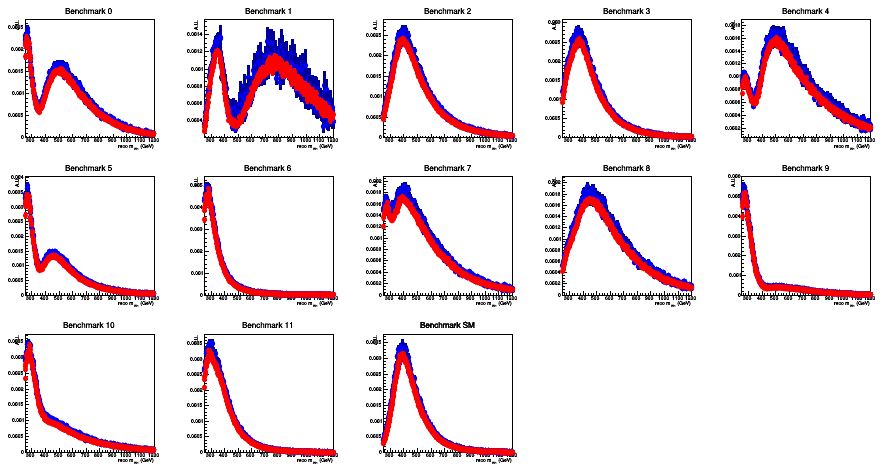

Info in <TCanvas::Print>: pdf file /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/reweighted_nodes/2016_2017/recodiHiggs_mass_2016_2017_14_03_2019.pdf has been created


In [197]:
sum=0.
c = TCanvas("c","c",900,500)
c.Divide(5,3)
file_dir = '/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2016_20191303/'

file_dir_2017 = '/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017_20191303/'
name='GluGluToHHTo2B2G_12nodes_13TeV_madgraph'
filename  = 'output_GluGluToHHTo2B2G_12nodes_13TeV-madgraph'
infile = TFile(file_dir+filename+'_2016_merged.root')
infile_2017 = TFile(file_dir_2017+filename+'_2017_merged.root')


hists_list=[]
hists_list_2017=[]
reco_gen = ['','_GenAll']
which_reco_gen = 0
diHiggs_mass = ['diHiggs_mass','mhh']
ranges = [500,250,1200]
i=0
nodes = list(np.arange(0,12,1))
nodes.append('SM')

for num_node in nodes:
    c.cd(i+1)
    tree_2017 = infile_2017.Get(name+reco_gen[which_reco_gen])
    hist_2017 = TH1F("hist_2017_%s"%num_node,"hist_2017_%s"%num_node,ranges[0],ranges[1],ranges[2])
    hist_2017.SetLineColor(2)
    hist_2017.SetMarkerColor(2)

    norm_value = normalization['2017']['benchmark_%s_normalization'%num_node]
    tree_2017.Draw("%s>>hist_2017_%s"%(diHiggs_mass[which_reco_gen],num_node),"weight*benchmark_reweight_%s/%s"%(num_node,norm_value))
    #  hist_2017.Scale(1./hist_2017.Integral())
  #  print '2017 Integral for benchmark ',num_node,' : ', hist_2017.Integral()
    
    tree = infile.Get(name+reco_gen[which_reco_gen])
    hist = TH1F("hist_2016_%s"%num_node,"hist_2016_%s"%num_node,ranges[0],ranges[1],ranges[2])
    hist.SetTitle("Benchmark %s"%(num_node))
    if which_reco_gen ==0 : hist.GetXaxis().SetTitle('reco m_{HH} (GeV)')
    else : hist.GetXaxis().SetTitle('gen m_{HH} (GeV)')

    hist.GetYaxis().SetTitle('A.U.')
    ROOT.gStyle.SetOptTitle(1)
    ROOT.gStyle.SetOptStat(0)
    norm_value = normalization['2016']['benchmark_%s_normalization'%num_node]
    tree.Draw("%s>>hist_2016_%s"%(diHiggs_mass[which_reco_gen],num_node),"weight*benchmark_reweight_%s/%s"%(num_node,norm_value))

  #  hist.Scale(1./hist.Integral())
 #   print '2016 Integral for benchmark ',num_node,' : ', hist.Integral()

    print '2016/2017 Integral for benchmark ',num_node,' : ', hist.Integral()/hist_2017.Integral()

    
    hist.Draw("APsame")
    hists_list.append(hist)
    hist_2017.Draw("same")
    hists_list_2017.append(hist_2017)
    
    hists_list.append(hist_sum)
    hists_list_2017.append(hist_sum_2017)


    i+=1
c.Draw()
if which_reco_gen ==0 : c.SaveAs(plot_dir+'recodiHiggs_mass_2016_2017_'+date+'.pdf')
else : c.SaveAs(plot_dir+'gendiHiggs_mass_2016_2017_'+date+'.pdf')

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c


2016/2017 Integral for sum 12 benchmark and SM  5.04545105062 4.6697395076 1.08045663841


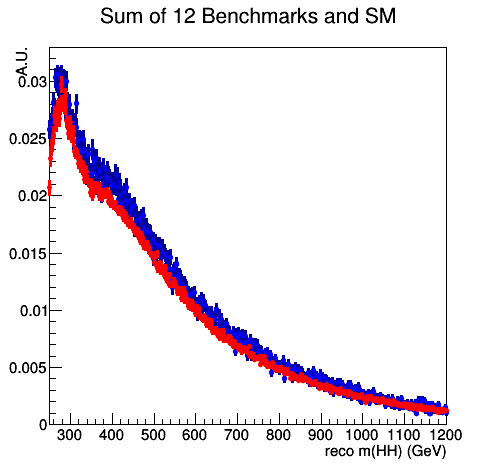

Info in <TCanvas::Print>: pdf file /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/reweighted_nodes/2016_2017/recodiHiggs_mass_sum_benchmarksSM_2016_2017_14_03_2019.pdf has been created


In [214]:
sum=0.
c = TCanvas("c","c",500,500)
file_dir = '/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2016_20191303/'

file_dir_2017 = '/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017_20191303/'
name='GluGluToHHTo2B2G_12nodes_13TeV_madgraph'
filename  = 'output_GluGluToHHTo2B2G_12nodes_13TeV-madgraph'
infile = TFile(file_dir+filename+'_2016_merged.root')
infile_2017 = TFile(file_dir_2017+filename+'_2017_merged.root')


hists_list=[]
hists_list_2017=[]
reco_gen = ['','_GenAll']
which_reco_gen = 0
diHiggs_mass = ['diHiggs_mass','mhh']
ranges = [500,250,1200]
nodes = list(np.arange(0,12,1))
nodes.append('SM')
hist_sum_2017 = TH1F("hist_sum_2017","hist_sum_2017",ranges[0],ranges[1],ranges[2])
hist_sum_2017.SetLineColor(2)
hist_sum_2017.SetMarkerColor(2)
hist_sum = TH1F("hist_sum","hist_sum",ranges[0],ranges[1],ranges[2])

reweighting_str_2017=''
reweighting_str=''

norm_value = normalization['2017']['benchmark_SM_normalization']
reweighting_str_2017+="weight*(benchmark_reweight_SM/%s"%(norm_value)
norm_value = normalization['2016']['benchmark_SM_normalization']
reweighting_str+="weight*(benchmark_reweight_SM/%s"%(norm_value)

nodes = list(np.arange(0,12,1))
for num_node in nodes:
    norm_value = normalization['2017']['benchmark_%s_normalization'%num_node]
    reweighting_str_2017+="+ benchmark_reweight_%s/%s"%(num_node,norm_value)

    norm_value = normalization['2016']['benchmark_%s_normalization'%num_node]
    reweighting_str+="+ benchmark_reweight_%s/%s"%(num_node,norm_value)
reweighting_str_2017+=')'
reweighting_str+=')'
    
tree_2017 = infile_2017.Get(name+reco_gen[which_reco_gen])
tree_2017.Draw("%s>>hist_sum_2017"%(diHiggs_mass[which_reco_gen]),"%s"%(reweighting_str_2017))

tree = infile.Get(name+reco_gen[which_reco_gen])
tree.Draw("%s>>hist_sum"%(diHiggs_mass[which_reco_gen]),"%s"%(reweighting_str))

hist_sum.SetTitle("Sum of 12 Benchmarks and SM")
hist_sum.GetXaxis().SetTitle('reco m(HH) (GeV)')
hist_sum.GetYaxis().SetTitle('A.U.')
ROOT.gStyle.SetOptTitle(1)
ROOT.gStyle.SetOptStat(0)

hist_sum.Draw("APsame")
hist_sum_2017.Draw("same")

print '2016/2017 Integral for sum 12 benchmark and SM ',hist_sum.Integral(), hist_sum_2017.Integral(), hist_sum.Integral()/hist_sum_2017.Integral()

    
c.Draw()
c.SaveAs(plot_dir+'recodiHiggs_mass_sum_benchmarksSM_2016_2017_'+date+'.pdf')


## Plot the difference in pT of Gen Higgses

In [166]:
import pandas as pd
import root_pandas as rpd
import gen_utils as gen_utils
import matplotlib.pyplot as plt


df1 = rpd.read_root('/work/nchernya/CMSSW_9_4_9/src/flashgg/output_trees_nottH_properSM2016GEN_11_03_2019/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root',
                  'genDiphotonDumper/trees/GluGluToHHTo2B2G_node_SM_13TeV_madgraph_13TeV_DoubleHTag_0')
df2 = rpd.read_root('/work/nchernya/CMSSW_9_4_9/src/flashgg/output_trees_nottH_properSM2016GEN_11_03_2019/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root',
                  'genDiphotonDumper/trees/GluGluToHHTo2B2G_node_SM_13TeV_madgraph_13TeV_NoTag_0')
df = pd.concat([df1,df2],ignore_index=True)

Index([u'candidate_id', u'weight', u'mgg', u'mbb', u'mhh', u'leadPho_px',
       u'leadPho_py', u'leadPho_pz', u'leadPho_e', u'subleadPho_px',
       u'subleadPho_py', u'subleadPho_pz', u'subleadPho_e', u'leadJet_px',
       u'leadJet_py', u'leadJet_pz', u'leadJet_e', u'subleadJet_px',
       u'subleadJet_py', u'subleadJet_pz', u'subleadJet_e', u'rho', u'nvtx',
       u'event', u'lumi', u'processIndex', u'run', u'npu', u'puweight'],
      dtype='object')

In [167]:
for part in "leadPho","subleadPho","leadJet","subleadJet":
    gen_utils.calc_p4extra(df,part) #calculating pt, eta, phi, m for each 
gen_utils.calc_sump4(df,"hgg","leadPho","subleadPho") #calculating pt, eta, phi, m for sum of 2 photons
gen_utils.calc_sump4(df,"hbb","leadJet","subleadJet") #calculating pt, eta, phi, m for sum of 2 b jets

In [173]:
#df[['hbb_pt','hgg_pt']]

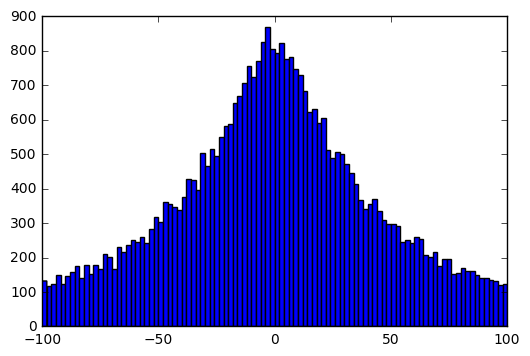

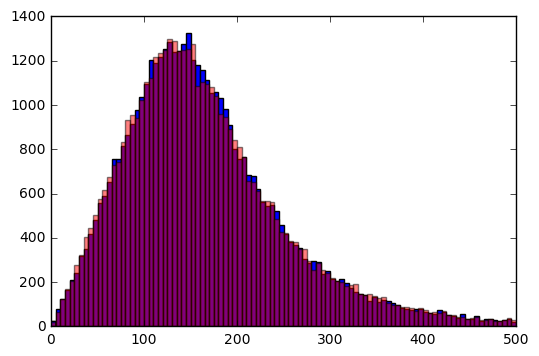

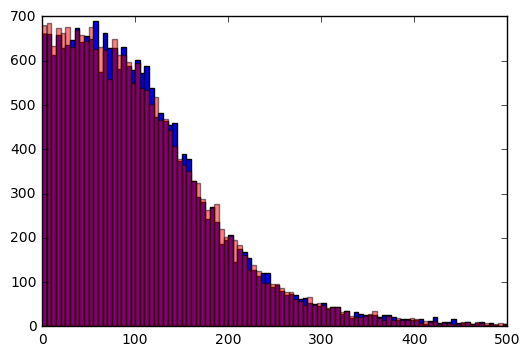

In [169]:
df['pt_diff'] = df['hbb_pt']-df['hgg_pt']

n, bins, patches = plt.hist(df['pt_diff'].values,100, range=(-100,100))
plt.show()

n, bins, patches = plt.hist(df['hgg_pt'].values,100, range=(0,500))
n, bins, patches = plt.hist(df['hbb_pt'].values,100, range=(0,500),color = 'r',alpha=0.5)
plt.show()

n, bins, patches = plt.hist(df['hgg_px'].values,100, range=(0,500))
n, bins, patches = plt.hist(-df['hbb_px'].values,100, range=(0,500),color = 'r',alpha=0.5)
plt.show()

## Compare SM generated and reweighted

In [128]:
infile_2016 = '/work/nchernya/CMSSW_9_4_9/src/flashgg/output_trees_nottH_nodeswithSM2016_11_03_2019/output_GluGluToHHTo2B2G_12nodes_13TeV-madgraph.root'
infile_2017 = '/work/nchernya/CMSSW_9_4_9/src/flashgg/output_trees_nottH_nodeswithSM2017_11_03_2019/output_GluGluToHHTo2B2G_12nodes_13TeV-madgraph_correctedcfg.root'   #2017 nodes 

#SMfile_2016 = '/work/nchernya/CMSSW_9_4_9/src/flashgg/output_trees_nottH_properSM2016_11_03_2019/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root'
SMfile_2016 = '/work/nchernya/CMSSW_9_4_9/src/flashgg/output_trees_nottH_properSM2016GEN_11_03_2019/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root'
SMfile_2017 = '/work/nchernya/CMSSW_9_4_9/src/flashgg/output_trees_nottH_properSM2017_11_03_2019/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root' 
#SMfile_2017 = '/work/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017_20181210/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root'

plot_dir = '/work/nchernya/HHbbgg_ETH_devel/Training/plots/reweighted_nodes/reweighted_generated/'
date = '13_03_2019' 

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c


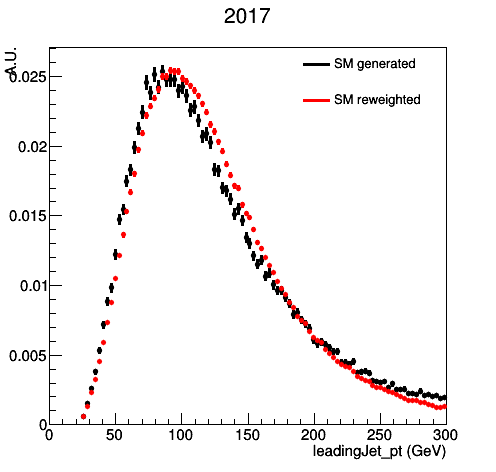

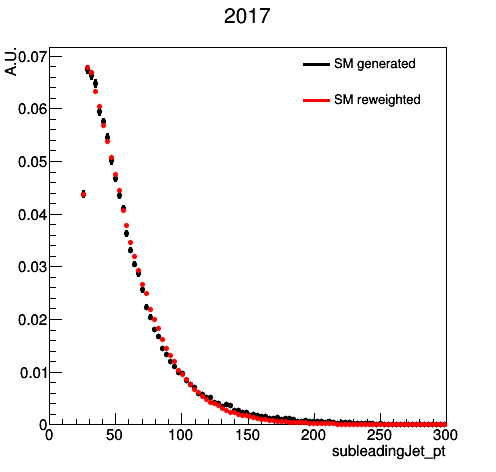

Info in <TCanvas::Print>: pdf file /work/nchernya/HHbbgg_ETH_devel/Training/plots/reweighted_nodes/reweighted_generated/comparison_reweighred_tagsDumper_2017_leadingJet_pt_13_03_2019.pdf has been created
Info in <TCanvas::Print>: pdf file /work/nchernya/HHbbgg_ETH_devel/Training/plots/reweighted_nodes/reweighted_generated/comparison_reweighred_tagsDumper_2017_subleadingJet_pt_13_03_2019.pdf has been created


In [130]:
c = TCanvas("c","c",500,500)
name2017='GluGluToHHTo2B2G_12nodes_13TeV_madgraph_correctedcfg_13TeV_DoubleHTag_0'
name2016='GluGluToHHTo2B2G_12nodes_13TeV_madgraph_13TeV_DoubleHTag_0'
nameSM = 'GluGluToHHTo2B2G_node_SM_13TeV_madgraph_13TeV_DoubleHTag_0'
nameGenSM = 'GluGluToHHTo2B2G_node_SM_13TeV_madgraph_13TeV_NoTag_0'
nameGen2017='GluGluToHHTo2B2G_12nodes_13TeV_madgraph_correctedcfg_13TeV_NoTag_0'
nameGen2016='GluGluToHHTo2B2G_12nodes_13TeV_madgraph_13TeV_NoTag_0'

#distributions = ['MX','diphotonCandidatePtOverdiHiggsM','dijetCandidatePtOverdiHiggsM','diHiggs_pt']
distributions = ['mhh']
units = [' (GeV)','','',' (GeV)']
ranges = [[500,250,1200],[100,0,3],[100,0,2],[500,0,1200]]

distributions = ['leadingJet_pt','subleadingJet_pt']
ranges = [[100,0,300],[100,0,300]]


genreco ='tagsDumper'
#genreco = 'genDiphotonDumper'
for year in [2017]:
#for year in [2016,2017]:

    if year==2016 : 
        name = name2016
        infile = TFile(infile_2016)
        infileSM = TFile(SMfile_2016)
        nameGen = nameGen2016
    else : 
        infile = TFile(infile_2017)
        name = name2017
        infileSM = TFile(SMfile_2017)
        nameGen = nameGen2017
    for num,distr in enumerate(distributions):
        hists_list=[]
        tree = infile.Get('%s/trees/%s'%(genreco,name))
        treeGen = infile.Get('%s/trees/%s'%(genreco,nameGen))

        hist_nodes = TH1F("hist_nodes_%d_%s"%(year,distr),"hist_nodes_%d_%s"%(year,distr),ranges[num][0],ranges[num][1],ranges[num][2])
        hist_nodes.SetLineColor(2)
        hist_nodes.SetMarkerColor(2)
        tree.Draw("%s>>hist_nodes_%d_%s"%(distr,year,distr),"weight*benchmark_reweight_SM")
       # treeGen.Draw("%s>>+hist_nodes_%d_%s"%(distr,year,distr),"weight*benchmark_reweight_SM")
        hist_nodes.Scale(1./hist_nodes.Integral())
        hists_list.append(hist_nodes)
    
        treeSM = infileSM.Get('%s/trees/%s'%(genreco,nameSM))
        treeSMGen = infileSM.Get('%s/trees/%s'%(genreco,nameGenSM))

        hist = TH1F("hist_SM_%d_%s"%(year,distr),"hist_SM_%d_%s"%(year,distr),ranges[num][0],ranges[num][1],ranges[num][2])
        hist.SetLineColor(2)
        hist.SetMarkerColor(2)
        treeSM.Draw("%s>>hist_SM_%d_%s"%(distr,year,distr),"weight")
       # treeSMGen.Draw("%s>>+hist_SM_%d_%s"%(distr,year,distr),"weight")

        
        hist.Scale(1./hist.Integral())
        hist.SetLineColor(1)
        hist.SetMarkerColor(1)

        hist.SetTitle('%d'%year)
        hist.GetYaxis().SetTitle('A.U.')
        hist.GetYaxis().SetTitleOffset(1.4)
        hist.GetXaxis().SetTitle(distr +units[num])
        ROOT.gStyle.SetOptTitle(1)
        ROOT.gStyle.SetOptStat(0)
        leg = TLegend(0.6,0.75,0.9,0.9)
        leg.AddEntry(hist,"SM generated" ,"L")
        leg.AddEntry(hist_nodes,"SM reweighted" ,"L")
        leg.SetFillStyle(-1)
        leg.SetBorderSize(0)
        leg.SetTextFont(42)
        leg.SetTextSize(0.03)
        leg.Draw()

    
        hist.Draw("APsame")
        hists_list.append(hist)
        hist_nodes.Draw("same")
        hists_list.append(hist_nodes)
    
        c.Draw()
        c.SaveAs(plot_dir+'comparison_reweighred_%s_%d_%s_'%(genreco,year,distr)+date+'.pdf')
